## Test whether there is a ramping effect of tFUS on FC
- Compute windowed FC (dynamic FC or dFC) before and after each tFUS onset
- Finding: no consistent pattern was observed. The effect of tFUS is strongest in the post period, and acute effects were weaker in this dataset. This is consistent with the literature on offline effects of tFUS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from nilearn import input_data, datasets, plotting, signal
from scipy import stats
import os
import pickle

In [4]:
with open('../data/precomputed/difumo_time_series.pkl', 'rb') as f:
    time_series = pickle.load(f)

bold_3d_active = np.array(time_series['active'])
bold_3d_sham = np.array(time_series['sham'])

print(f"Shape of bold_3d_active: {bold_3d_active.shape} (subjects, time points, ROIs)")
print(f"Shape of bold_3d_sham: {bold_3d_sham.shape} (subjects, time points, ROIs)")

N_SUBJECTS, N_TIMEPOINTS, N_ROIS = bold_3d_active.shape

Shape of bold_3d_active: (16, 900, 1024) (subjects, time points, ROIs)
Shape of bold_3d_sham: (16, 900, 1024) (subjects, time points, ROIs)


In [31]:
# define onsets
ONSETS = [300, 360, 420, 480, 540]
SAMPLES_BEFORE = 40
SAMPLES_AFTER = 20
SGG_ROI_IDX = 133

df = pd.DataFrame(columns=['subject', 'condition', 'onset', 'time_window',  'FC'])
data = []

for onset in ONSETS:
    print(f"Onset: {onset}")
    IDX_PRE = range(onset - SAMPLES_BEFORE, onset)
    IDX_FUS = range(onset, onset + SAMPLES_AFTER)
    IDX_POST = range(onset + SAMPLES_AFTER, onset + SAMPLES_AFTER + SAMPLES_BEFORE)

    for s in range(N_SUBJECTS):
        #bold_3d_active[s,:,:] = signal.clean(bold_3d_active[s,:,:], detrend=False, standardize=False)
        #bold_3d_sham[s,:,:] = signal.clean(bold_3d_sham[s,:,:], detrend=False, standardize=False)
        corrmat_active_pre = np.corrcoef(bold_3d_active[s,IDX_PRE,:].T)
        corrmat_active_fus = np.corrcoef(bold_3d_active[s,IDX_FUS,:].T)
        corrmat_active_post = np.corrcoef(bold_3d_active[s,IDX_POST,:].T)
        corrmat_sham_pre = np.corrcoef(bold_3d_sham[s,IDX_PRE,:].T)
        corrmat_sham_fus = np.corrcoef(bold_3d_sham[s,IDX_FUS,:].T)
        corrmat_sham_post = np.corrcoef(bold_3d_sham[s,IDX_POST,:].T)
        
        # extract the FC of the sgACC
        sgacc_fc_active_pre = np.mean(corrmat_active_pre[SGG_ROI_IDX,np.setdiff1d(np.arange(N_ROIS), SGG_ROI_IDX)])
        sgacc_fc_active_fus = np.mean(corrmat_active_fus[SGG_ROI_IDX,np.setdiff1d(np.arange(N_ROIS), SGG_ROI_IDX)])
        sgacc_fc_active_post = np.mean(corrmat_active_post[SGG_ROI_IDX,np.setdiff1d(np.arange(N_ROIS), SGG_ROI_IDX)])
        sgacc_fc_sham_pre = np.mean(corrmat_sham_pre[SGG_ROI_IDX,np.setdiff1d(np.arange(N_ROIS), SGG_ROI_IDX)])
        sgacc_fc_sham_fus = np.mean(corrmat_sham_fus[SGG_ROI_IDX,np.setdiff1d(np.arange(N_ROIS), SGG_ROI_IDX)])
        sgacc_fc_sham_post = np.mean(corrmat_sham_post[SGG_ROI_IDX,np.setdiff1d(np.arange(N_ROIS), SGG_ROI_IDX)])
        
        # fill the dataframe
        data.append({
            'subject': s,
            'condition': 'active',
            'onset': onset,
            'time_window': 'pre',
            'FC': sgacc_fc_active_pre
        })

        data.append({
            'subject': s,
            'condition': 'active',
            'onset': onset,
            'time_window': 'fus',
            'FC': sgacc_fc_active_fus
        })

        data.append({
            'subject': s,
            'condition': 'active',
            'onset': onset,
            'time_window': 'post',
            'FC': sgacc_fc_active_post
        })

        data.append({
            'subject': s,
            'condition': 'sham',
            'onset': onset,
            'time_window': 'pre',
            'FC': sgacc_fc_sham_pre
        })  

        data.append({
            'subject': s,
            'condition': 'sham',
            'onset': onset,
            'time_window': 'fus',
            'FC': sgacc_fc_sham_fus
        })      

        data.append({
            'subject': s,
            'condition': 'sham',
            'onset': onset,
            'time_window': 'post',
            'FC': sgacc_fc_sham_post
        })  


Onset: 300
Onset: 360
Onset: 420
Onset: 480
Onset: 540


In [32]:
df = pd.DataFrame(data)
df.head()

dfg = df.groupby(['onset','time_window', 'condition']).mean().reset_index()

/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_49046/3135763588.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=dfg_active, x='onset', y='FC', hue='time_window', ci=None, hue_order=['pre', 'fus', 'post'], ax=ax[0])
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_49046/3135763588.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=dfg_sham, x='onset', y='FC', hue='time_window', ci=None, hue_order=['pre', 'fus', 'post'], ax=ax[1])


<Axes: xlabel='onset', ylabel='FC'>

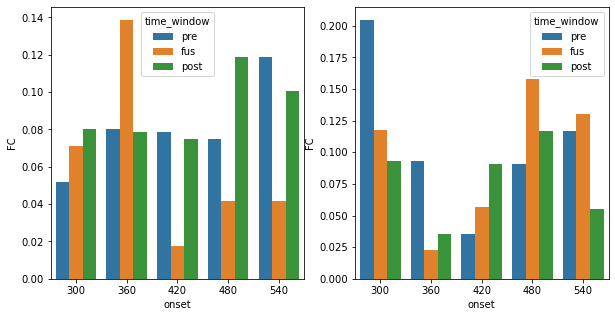

In [33]:
import seaborn as sns

dfg_active = dfg[dfg['condition'] == 'active']
dfg_sham = dfg[dfg['condition'] == 'sham']

# order time windows
dfg['time_window'] = pd.Categorical(dfg['time_window'], categories=['pre', 'fus', 'post'], ordered=True)
dfg = dfg.sort_values('time_window')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(data=dfg_active, x='onset', y='FC', hue='time_window', ci=None, hue_order=['pre', 'fus', 'post'], ax=ax[0])
sns.barplot(data=dfg_sham, x='onset', y='FC', hue='time_window', ci=None, hue_order=['pre', 'fus', 'post'], ax=ax[1])


In [ ]:
sns.barplot(data=dfg, x='onset', y='FC', hue='time_window', ci=None)

In [ ]:

# compute functional connectivity matrix for each subject and condition
for s in range(bold_3d_active.shape[0]):
    bold_3d_active[s,:,:] = signal.clean(bold_3d_active[s,:,:], detrend=False, standardize=False)
    bold_3d_sham[s,:,:] = signal.clean(bold_3d_sham[s,:,:], detrend=False, standardize=False)
    
    # compute functional connectivity matrix for this subject and condition
    corrmat_active_pre = np.corrcoef(bold_3d_active[s,IDX_PRE,:].T)
    corrmat_active_fus = np.corrcoef(bold_3d_active[s,IDX_FUS,:].T)
    corrmat_active_post = np.corrcoef(bold_3d_active[s,IDX_POST,:].T)
    
    corrmat_sham_pre = np.corrcoef(bold_3d_sham[s,IDX_PRE,:].T)
    corrmat_sham_fus = np.corrcoef(bold_3d_sham[s,IDX_FUS,:].T)
    corrmat_sham_post = np.corrcoef(bold_3d_sham[s,IDX_POST,:].T)
    
    if s == 0:
        all_corrmat_active_pre = corrmat_active_pre
        all_corrmat_active_fus = corrmat_active_fus
        all_corrmat_active_post = corrmat_active_post
        
        all_corrmat_sham_pre = corrmat_sham_pre
        all_corrmat_sham_fus = corrmat_sham_fus
        all_corrmat_sham_post = corrmat_sham_post
        
    else:
        all_corrmat_active_pre = np.dstack((all_corrmat_active_pre, corrmat_active_pre))
        all_corrmat_active_fus = np.dstack((all_corrmat_active_fus, corrmat_active_fus))
        all_corrmat_active_post = np.dstack((all_corrmat_active_post, corrmat_active_post))
        
        all_corrmat_sham_pre = np.dstack((all_corrmat_sham_pre, corrmat_sham_pre))
        all_corrmat_sham_fus = np.dstack((all_corrmat_sham_fus, corrmat_sham_fus))
        all_corrmat_sham_post = np.dstack((all_corrmat_sham_post, corrmat_sham_post))